# Project Source : https://plainenglish.io/blog/denoising-autoencoder-in-pytorch-on-mnist-dataset-a76b8824e57e

In [4]:
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split

import torch.optim as optim
import torchvision
from torchvision import transforms
# import ppscore as pps
import datetime
import ppscore as pps
import random
from torchsummary import summary
import bokeh
from bokeh.plotting import figure, show
pd.set_option("display.max_columns",80)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.set_option("display.max_rows",80)
import tslumen
import tqdm as notebook_tqdm
import datetime as dt
from tslumen import HtmlReport
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tqdm as notebook_tqdm
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [5]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

100%|██████████| 9912422/9912422 [00:19<00:00, 513889.03it/s]


Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28883093.42it/s]

Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw



100%|██████████| 1648877/1648877 [00:03<00:00, 548630.25it/s]


Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw



# Encoder

In [6]:
class Encoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()

		### Convolutional section
		self.encoder_cnn = nn.Sequential(
		nn.Conv2d(1, 8, 3, stride=2, padding=1),
		nn.ReLU(True),
		nn.Conv2d(8, 16, 3, stride=2, padding=1),
		nn.BatchNorm2d(16),
		nn.ReLU(True),
		nn.Conv2d(16, 32, 3, stride=2, padding=0),
		nn.ReLU(True)
		)

		### Flatten layer
		self.flatten = nn.Flatten(start_dim=1)
### Linear section
		self.encoder_lin = nn.Sequential(
			nn.Linear(3 * 3 * 32, 128),
			nn.ReLU(True),
			nn.Linear(128, encoded_space_dim)
		)

	def forward(self, x):
		x = self.encoder_cnn(x)
		x = self.flatten(x)
		x = self.encoder_lin(x)
		return x

# Decoder

In [7]:
class Decoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()
		self.decoder_lin = nn.Sequential(
			nn.Linear(encoded_space_dim, 128),
			nn.ReLU(True),
			nn.Linear(128, 3 * 3 * 32),
			nn.ReLU(True)
		)

		self.unflatten = nn.Unflatten(dim=1,
		unflattened_size=(32, 3, 3))

		self.decoder_conv = nn.Sequential(
			nn.ConvTranspose2d(32, 16, 3,
			stride=2, output_padding=0),
			nn.BatchNorm2d(16),
			nn.ReLU(True),
			nn.ConvTranspose2d(16, 8, 3, stride=2,
			padding=1, output_padding=1),
			nn.BatchNorm2d(8),
			nn.ReLU(True),
			nn.ConvTranspose2d(8, 1, 3, stride=2,
			padding=1, output_padding=1)
		)

	def forward(self, x):
		x = self.decoder_lin(x)
		x = self.unflatten(x)
		x = self.decoder_conv(x)
		x = torch.sigmoid(x)
		return x

# Initialization

In [8]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
	{'params': encoder.parameters()},
	{'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Adding Noise

In [9]:
def add_noise(inputs,noise_factor=0.3):
	noisy = inputs+torch.randn_like(inputs) * noise_factor
	noisy = torch.clip(noisy,0.,1.)
	return noisy

# Training Function

In [10]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
	# Set train mode for both the encoder and the decoder
	encoder.train()
	decoder.train()
	train_loss = []
	# Iterate the dataloader (we do not need the label values, this is unsupervised learning)
	for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
		# Move tensor to the proper device
		image_noisy = add_noise(image_batch,noise_factor)
		image_batch = image_batch.to(device)
		image_noisy = image_noisy.to(device)
		# Encode data
		encoded_data = encoder(image_noisy)
		# Decode data
		decoded_data = decoder(encoded_data)
		# Evaluate loss
		loss = loss_fn(decoded_data, image_batch)
		# Backward pass
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		# Print batch loss
		print('\t partial train loss (single batch): %f' % (loss.data))
		train_loss.append(loss.detach().cpu().numpy())

	return np.mean(train_loss)

# Test function

In [11]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
	# Set evaluation mode for encoder and decoder
	encoder.eval()
	decoder.eval()
	with torch.no_grad(): # No need to track the gradients
		# Define the lists to store the outputs for each batch
		conc_out = []
		conc_label = []
		for image_batch, _ in dataloader:
			# Move tensor to the proper device
			image_noisy = add_noise(image_batch,noise_factor)
			image_noisy = image_noisy.to(device)
			# Encode data
			encoded_data = encoder(image_noisy)
			# Decode data
			decoded_data = decoder(encoded_data)
			# Append the network output and the original image to the lists
			conc_out.append(decoded_data.cpu())
			conc_label.append(image_batch.cpu())
		# Create a single tensor with all the values in the lists
		conc_out = torch.cat(conc_out)
		conc_label = torch.cat(conc_label)
		# Evaluate global loss
		val_loss = loss_fn(conc_out, conc_label)
	return val_loss.data

# Results Visualization

In [12]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
	plt.figure(figsize=(16,4.5))
	targets = test_dataset.targets.numpy()
	t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
	for i in range(n):

		ax = plt.subplot(3,n,i+1)
		img = test_dataset[t_idx[i]][0].unsqueeze(0)
		image_noisy = add_noise(img,noise_factor)
		image_noisy = image_noisy.to(device)

		encoder.eval()
		decoder.eval()

		with torch.no_grad():
			rec_img = decoder(encoder(image_noisy))

		plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Original images')
		ax = plt.subplot(3, n, i + 1 + n)
		plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Corrupted images')

		ax = plt.subplot(3, n, i + 1 + n + n)
		plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Reconstructed images')
	plt.subplots_adjust(left=0.1,
					bottom=0.1,
					right=0.7,
					top=0.9,
					wspace=0.3,
					hspace=0.3)
	plt.show()

# Training time

EPOCH 1/30
	 partial train loss (single batch): 0.253236
	 partial train loss (single batch): 0.245954
	 partial train loss (single batch): 0.240807
	 partial train loss (single batch): 0.235505
	 partial train loss (single batch): 0.231984
	 partial train loss (single batch): 0.228352
	 partial train loss (single batch): 0.225302
	 partial train loss (single batch): 0.222544
	 partial train loss (single batch): 0.220077
	 partial train loss (single batch): 0.217937
	 partial train loss (single batch): 0.215906
	 partial train loss (single batch): 0.213739
	 partial train loss (single batch): 0.211170
	 partial train loss (single batch): 0.209415
	 partial train loss (single batch): 0.207060
	 partial train loss (single batch): 0.205204
	 partial train loss (single batch): 0.203397
	 partial train loss (single batch): 0.201274
	 partial train loss (single batch): 0.199462
	 partial train loss (single batch): 0.197360
	 partial train loss (single batch): 0.195758
	 partial train loss (s

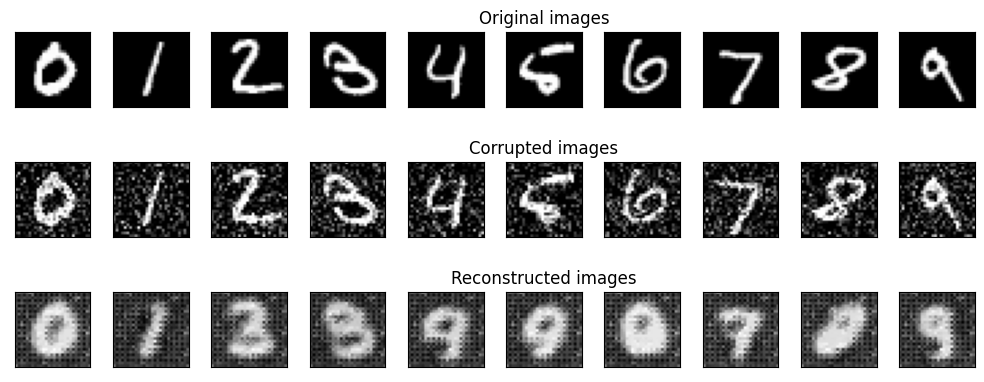

EPOCH 2/30
	 partial train loss (single batch): 0.066766
	 partial train loss (single batch): 0.065687
	 partial train loss (single batch): 0.065497
	 partial train loss (single batch): 0.067024
	 partial train loss (single batch): 0.065584
	 partial train loss (single batch): 0.064765
	 partial train loss (single batch): 0.064531
	 partial train loss (single batch): 0.064885
	 partial train loss (single batch): 0.065154
	 partial train loss (single batch): 0.064479
	 partial train loss (single batch): 0.064161
	 partial train loss (single batch): 0.063718
	 partial train loss (single batch): 0.064360
	 partial train loss (single batch): 0.062725
	 partial train loss (single batch): 0.063522
	 partial train loss (single batch): 0.062882
	 partial train loss (single batch): 0.063287
	 partial train loss (single batch): 0.064790
	 partial train loss (single batch): 0.063589
	 partial train loss (single batch): 0.061415
	 partial train loss (single batch): 0.061726
	 partial train loss (s

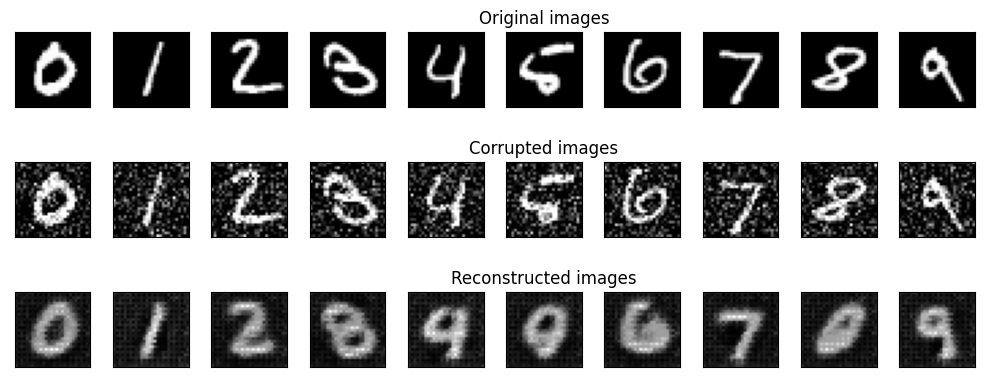

EPOCH 3/30
	 partial train loss (single batch): 0.046801
	 partial train loss (single batch): 0.045821
	 partial train loss (single batch): 0.045532
	 partial train loss (single batch): 0.047729
	 partial train loss (single batch): 0.046173
	 partial train loss (single batch): 0.045629
	 partial train loss (single batch): 0.045768
	 partial train loss (single batch): 0.046092
	 partial train loss (single batch): 0.046871
	 partial train loss (single batch): 0.046013
	 partial train loss (single batch): 0.045895
	 partial train loss (single batch): 0.045695
	 partial train loss (single batch): 0.046475
	 partial train loss (single batch): 0.045296
	 partial train loss (single batch): 0.046114
	 partial train loss (single batch): 0.045263
	 partial train loss (single batch): 0.046000
	 partial train loss (single batch): 0.047957
	 partial train loss (single batch): 0.046526
	 partial train loss (single batch): 0.044746
	 partial train loss (single batch): 0.044999
	 partial train loss (s

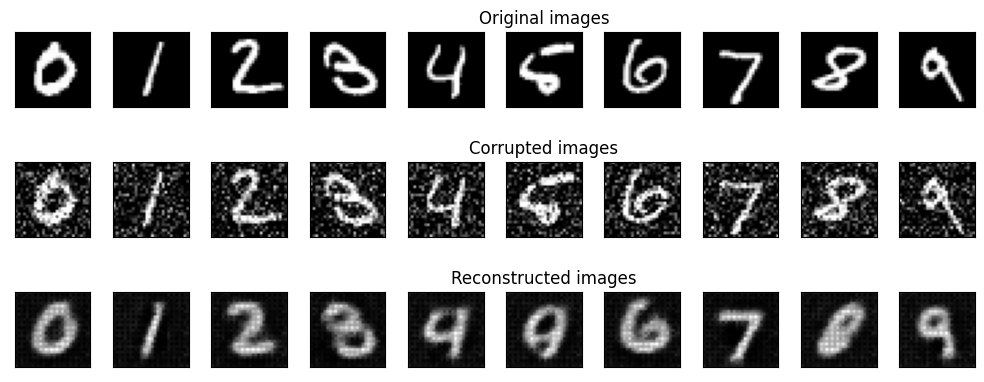

EPOCH 4/30
	 partial train loss (single batch): 0.037917
	 partial train loss (single batch): 0.036798
	 partial train loss (single batch): 0.037072
	 partial train loss (single batch): 0.038801
	 partial train loss (single batch): 0.037777
	 partial train loss (single batch): 0.037065
	 partial train loss (single batch): 0.037454
	 partial train loss (single batch): 0.037632
	 partial train loss (single batch): 0.038944
	 partial train loss (single batch): 0.038171
	 partial train loss (single batch): 0.037882
	 partial train loss (single batch): 0.037256
	 partial train loss (single batch): 0.038090
	 partial train loss (single batch): 0.037543
	 partial train loss (single batch): 0.038155
	 partial train loss (single batch): 0.037617
	 partial train loss (single batch): 0.038055
	 partial train loss (single batch): 0.039537
	 partial train loss (single batch): 0.038526
	 partial train loss (single batch): 0.036753
	 partial train loss (single batch): 0.036805
	 partial train loss (s

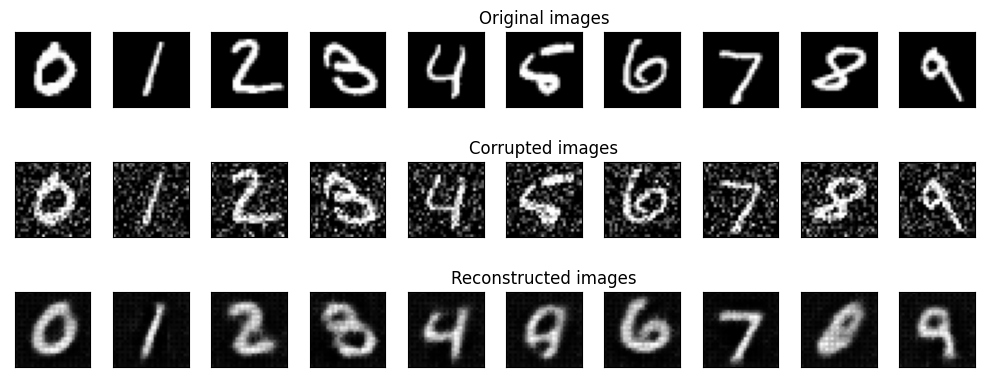

EPOCH 5/30
	 partial train loss (single batch): 0.033834
	 partial train loss (single batch): 0.032887
	 partial train loss (single batch): 0.032920
	 partial train loss (single batch): 0.035102
	 partial train loss (single batch): 0.033886
	 partial train loss (single batch): 0.033371
	 partial train loss (single batch): 0.033638
	 partial train loss (single batch): 0.033878
	 partial train loss (single batch): 0.035232
	 partial train loss (single batch): 0.034660
	 partial train loss (single batch): 0.034002
	 partial train loss (single batch): 0.033570
	 partial train loss (single batch): 0.034375
	 partial train loss (single batch): 0.033880
	 partial train loss (single batch): 0.034375
	 partial train loss (single batch): 0.033921
	 partial train loss (single batch): 0.034539
	 partial train loss (single batch): 0.035547
	 partial train loss (single batch): 0.034958
	 partial train loss (single batch): 0.033522
	 partial train loss (single batch): 0.033266
	 partial train loss (s

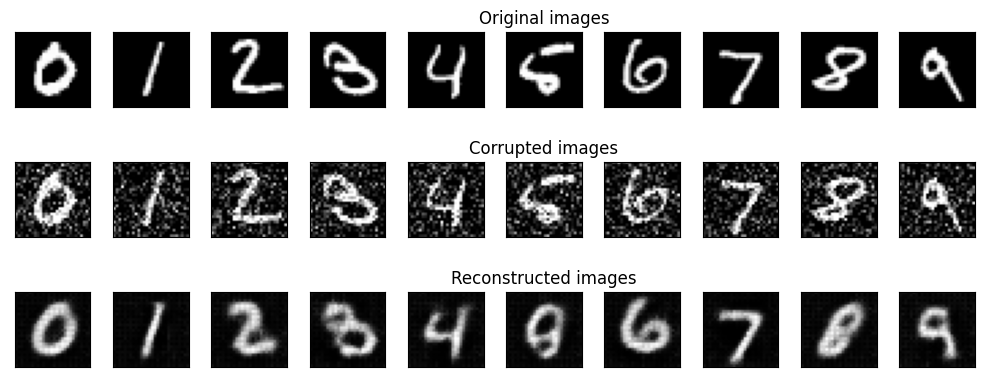

EPOCH 6/30
	 partial train loss (single batch): 0.032190
	 partial train loss (single batch): 0.030990
	 partial train loss (single batch): 0.031321
	 partial train loss (single batch): 0.032903
	 partial train loss (single batch): 0.032116
	 partial train loss (single batch): 0.031487
	 partial train loss (single batch): 0.031810
	 partial train loss (single batch): 0.032318
	 partial train loss (single batch): 0.033599
	 partial train loss (single batch): 0.032857
	 partial train loss (single batch): 0.032471
	 partial train loss (single batch): 0.031926
	 partial train loss (single batch): 0.032689
	 partial train loss (single batch): 0.032134
	 partial train loss (single batch): 0.032975
	 partial train loss (single batch): 0.032510
	 partial train loss (single batch): 0.032704
	 partial train loss (single batch): 0.033963
	 partial train loss (single batch): 0.032974
	 partial train loss (single batch): 0.031740
	 partial train loss (single batch): 0.031640
	 partial train loss (s

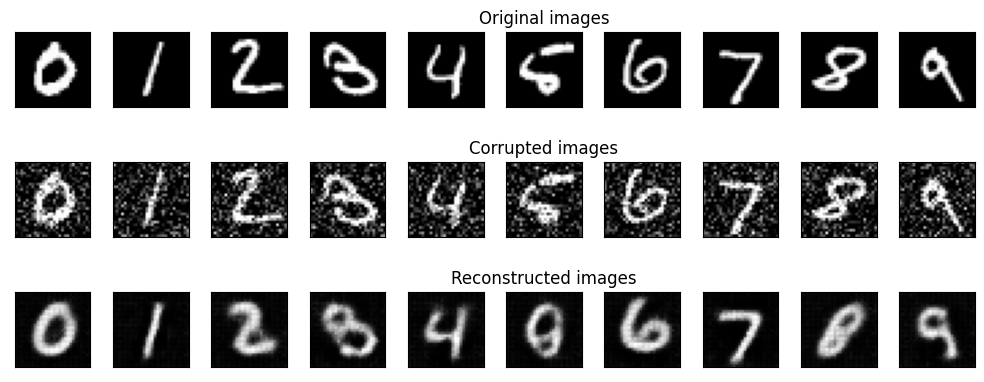

EPOCH 7/30
	 partial train loss (single batch): 0.031004
	 partial train loss (single batch): 0.029758
	 partial train loss (single batch): 0.030387
	 partial train loss (single batch): 0.031863
	 partial train loss (single batch): 0.030950
	 partial train loss (single batch): 0.030499
	 partial train loss (single batch): 0.030887
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch): 0.032481
	 partial train loss (single batch): 0.031349
	 partial train loss (single batch): 0.031478
	 partial train loss (single batch): 0.030925
	 partial train loss (single batch): 0.031433
	 partial train loss (single batch): 0.030902
	 partial train loss (single batch): 0.031671
	 partial train loss (single batch): 0.031504
	 partial train loss (single batch): 0.031680
	 partial train loss (single batch): 0.033104
	 partial train loss (single batch): 0.031928
	 partial train loss (single batch): 0.030682
	 partial train loss (single batch): 0.030540
	 partial train loss (s

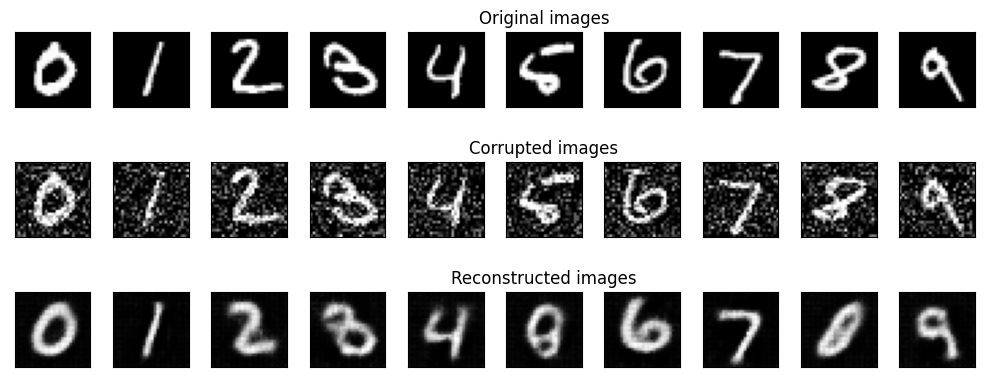

EPOCH 8/30
	 partial train loss (single batch): 0.030075
	 partial train loss (single batch): 0.029050
	 partial train loss (single batch): 0.029499
	 partial train loss (single batch): 0.031092
	 partial train loss (single batch): 0.030554
	 partial train loss (single batch): 0.029881
	 partial train loss (single batch): 0.029986
	 partial train loss (single batch): 0.030819
	 partial train loss (single batch): 0.031561
	 partial train loss (single batch): 0.030674
	 partial train loss (single batch): 0.030470
	 partial train loss (single batch): 0.029981
	 partial train loss (single batch): 0.030605
	 partial train loss (single batch): 0.029840
	 partial train loss (single batch): 0.030961
	 partial train loss (single batch): 0.030635
	 partial train loss (single batch): 0.030663
	 partial train loss (single batch): 0.032237
	 partial train loss (single batch): 0.031443
	 partial train loss (single batch): 0.029783
	 partial train loss (single batch): 0.029806
	 partial train loss (s

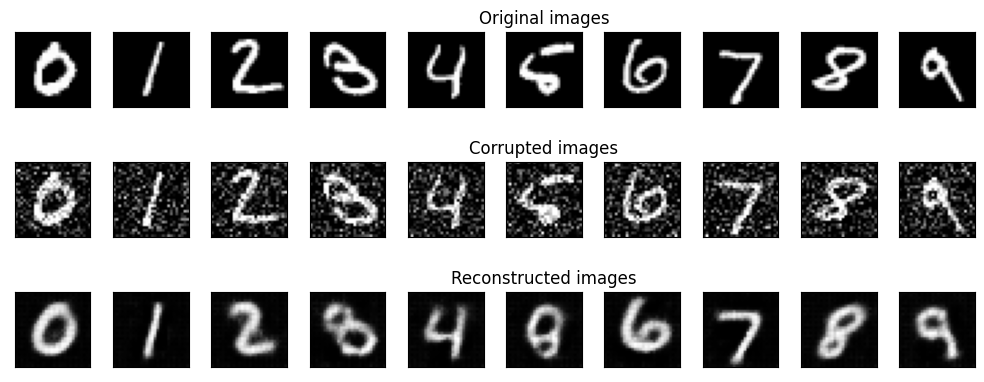

EPOCH 9/30
	 partial train loss (single batch): 0.029892
	 partial train loss (single batch): 0.028331
	 partial train loss (single batch): 0.028793
	 partial train loss (single batch): 0.030611
	 partial train loss (single batch): 0.029772
	 partial train loss (single batch): 0.029040
	 partial train loss (single batch): 0.029424
	 partial train loss (single batch): 0.029964
	 partial train loss (single batch): 0.031258
	 partial train loss (single batch): 0.029917
	 partial train loss (single batch): 0.030074
	 partial train loss (single batch): 0.029468
	 partial train loss (single batch): 0.030399
	 partial train loss (single batch): 0.029371
	 partial train loss (single batch): 0.030145
	 partial train loss (single batch): 0.030307
	 partial train loss (single batch): 0.029988
	 partial train loss (single batch): 0.031576
	 partial train loss (single batch): 0.031143
	 partial train loss (single batch): 0.029272
	 partial train loss (single batch): 0.029159
	 partial train loss (s

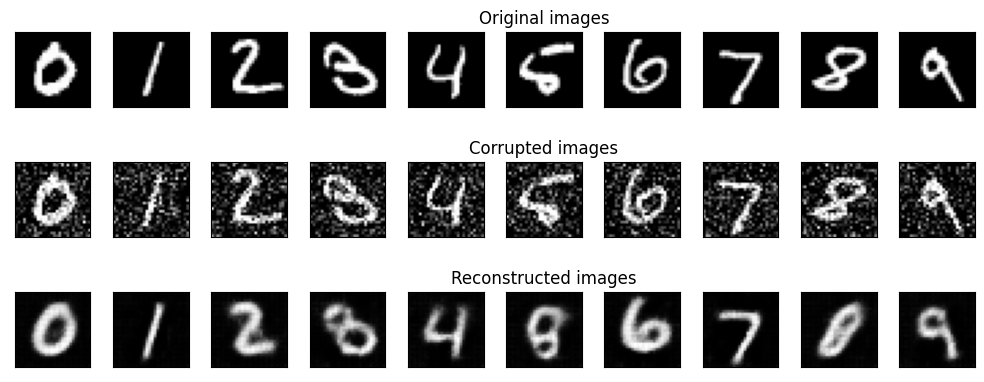

EPOCH 10/30
	 partial train loss (single batch): 0.029305
	 partial train loss (single batch): 0.027922
	 partial train loss (single batch): 0.028726
	 partial train loss (single batch): 0.030288
	 partial train loss (single batch): 0.029135
	 partial train loss (single batch): 0.028755
	 partial train loss (single batch): 0.028822
	 partial train loss (single batch): 0.029683
	 partial train loss (single batch): 0.030639
	 partial train loss (single batch): 0.029351
	 partial train loss (single batch): 0.029422
	 partial train loss (single batch): 0.029219
	 partial train loss (single batch): 0.029696
	 partial train loss (single batch): 0.029005
	 partial train loss (single batch): 0.030054
	 partial train loss (single batch): 0.029780
	 partial train loss (single batch): 0.029646
	 partial train loss (single batch): 0.031061
	 partial train loss (single batch): 0.030472
	 partial train loss (single batch): 0.028741
	 partial train loss (single batch): 0.028697
	 partial train loss (

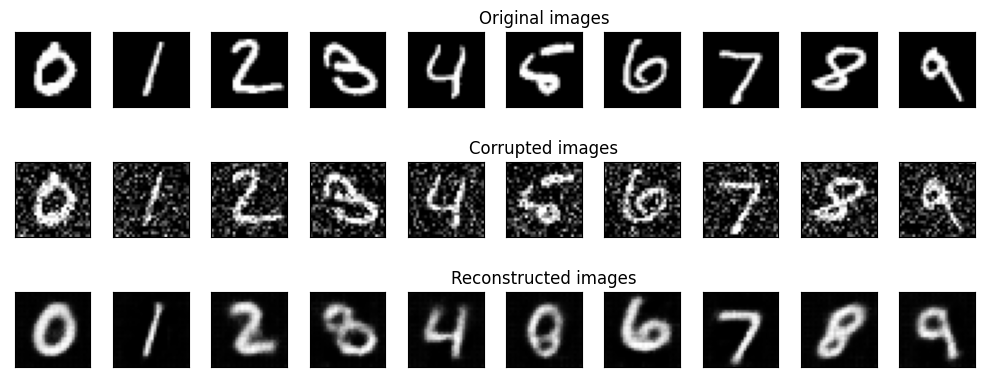

EPOCH 11/30
	 partial train loss (single batch): 0.028927
	 partial train loss (single batch): 0.027652
	 partial train loss (single batch): 0.028307
	 partial train loss (single batch): 0.030074
	 partial train loss (single batch): 0.028902
	 partial train loss (single batch): 0.028369
	 partial train loss (single batch): 0.028042
	 partial train loss (single batch): 0.029337
	 partial train loss (single batch): 0.030595
	 partial train loss (single batch): 0.029292
	 partial train loss (single batch): 0.029262
	 partial train loss (single batch): 0.029125
	 partial train loss (single batch): 0.029573
	 partial train loss (single batch): 0.028501
	 partial train loss (single batch): 0.029816
	 partial train loss (single batch): 0.029683
	 partial train loss (single batch): 0.029449
	 partial train loss (single batch): 0.031086
	 partial train loss (single batch): 0.030520
	 partial train loss (single batch): 0.028422
	 partial train loss (single batch): 0.028763
	 partial train loss (

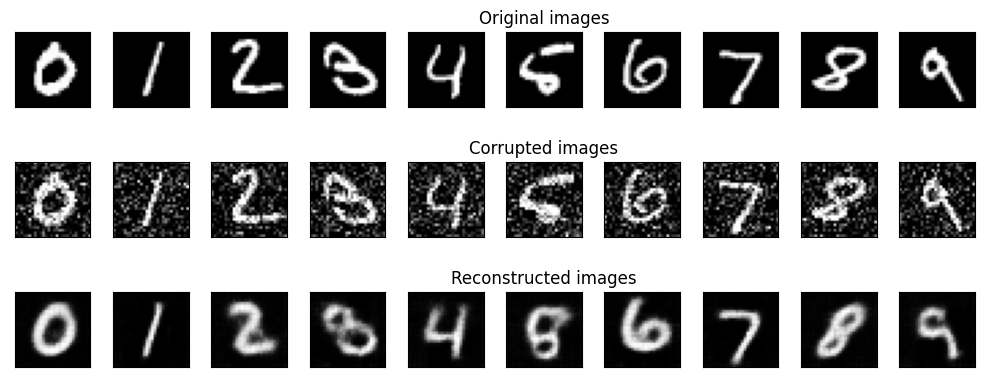

EPOCH 12/30
	 partial train loss (single batch): 0.028996
	 partial train loss (single batch): 0.027118
	 partial train loss (single batch): 0.027942
	 partial train loss (single batch): 0.029498
	 partial train loss (single batch): 0.028814
	 partial train loss (single batch): 0.027950
	 partial train loss (single batch): 0.027961
	 partial train loss (single batch): 0.028835
	 partial train loss (single batch): 0.030113
	 partial train loss (single batch): 0.028941
	 partial train loss (single batch): 0.029004
	 partial train loss (single batch): 0.028514
	 partial train loss (single batch): 0.029250
	 partial train loss (single batch): 0.027975
	 partial train loss (single batch): 0.029412
	 partial train loss (single batch): 0.029151
	 partial train loss (single batch): 0.028973
	 partial train loss (single batch): 0.030835
	 partial train loss (single batch): 0.029934
	 partial train loss (single batch): 0.028321
	 partial train loss (single batch): 0.028350
	 partial train loss (

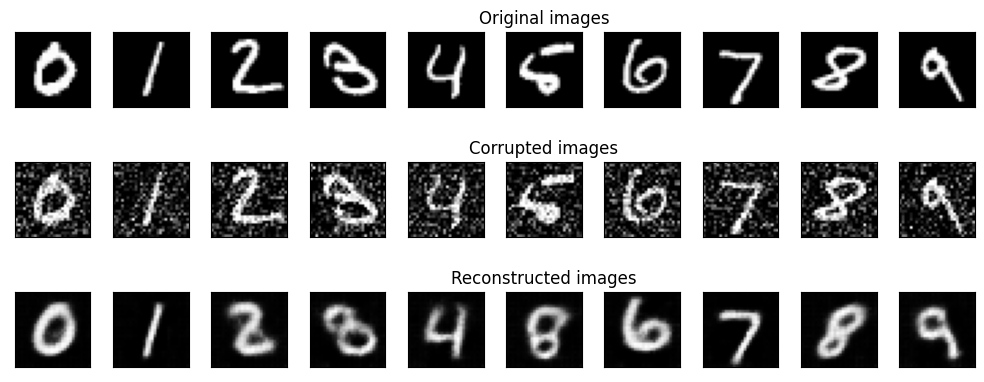

EPOCH 13/30
	 partial train loss (single batch): 0.028394
	 partial train loss (single batch): 0.026907
	 partial train loss (single batch): 0.027915
	 partial train loss (single batch): 0.029345
	 partial train loss (single batch): 0.028341
	 partial train loss (single batch): 0.027720
	 partial train loss (single batch): 0.028079
	 partial train loss (single batch): 0.028781
	 partial train loss (single batch): 0.029696
	 partial train loss (single batch): 0.028452
	 partial train loss (single batch): 0.028815
	 partial train loss (single batch): 0.028125
	 partial train loss (single batch): 0.029141
	 partial train loss (single batch): 0.027774
	 partial train loss (single batch): 0.029137
	 partial train loss (single batch): 0.029065
	 partial train loss (single batch): 0.028697
	 partial train loss (single batch): 0.030396
	 partial train loss (single batch): 0.029766
	 partial train loss (single batch): 0.028003
	 partial train loss (single batch): 0.028181
	 partial train loss (

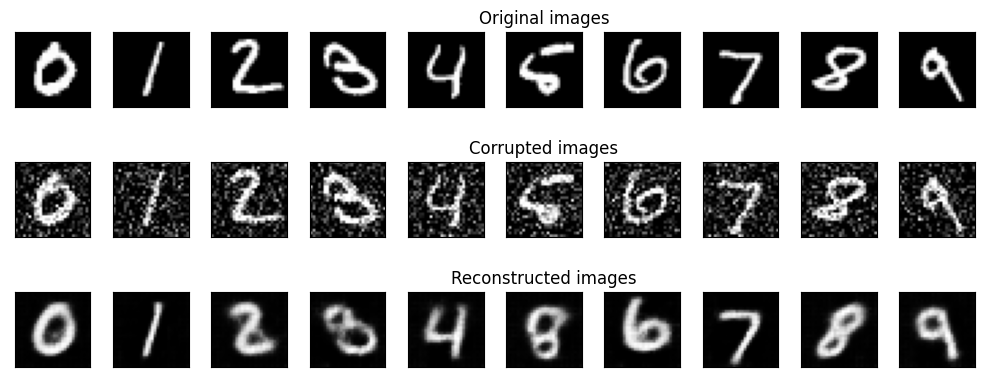

EPOCH 14/30
	 partial train loss (single batch): 0.028317
	 partial train loss (single batch): 0.026538
	 partial train loss (single batch): 0.027660
	 partial train loss (single batch): 0.028984
	 partial train loss (single batch): 0.028171
	 partial train loss (single batch): 0.027171
	 partial train loss (single batch): 0.027584
	 partial train loss (single batch): 0.028441
	 partial train loss (single batch): 0.029670
	 partial train loss (single batch): 0.028288
	 partial train loss (single batch): 0.028632
	 partial train loss (single batch): 0.028002
	 partial train loss (single batch): 0.028873
	 partial train loss (single batch): 0.027581
	 partial train loss (single batch): 0.029022
	 partial train loss (single batch): 0.028757
	 partial train loss (single batch): 0.028408
	 partial train loss (single batch): 0.030255
	 partial train loss (single batch): 0.029318
	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.027987
	 partial train loss (

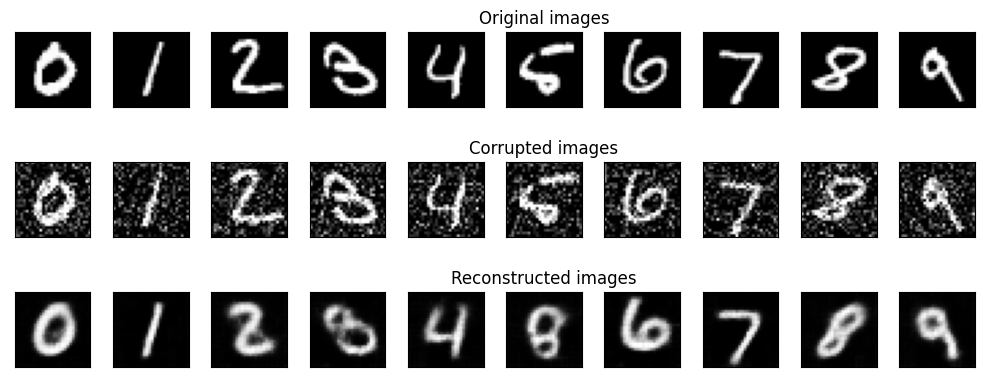

EPOCH 15/30
	 partial train loss (single batch): 0.028014
	 partial train loss (single batch): 0.026507
	 partial train loss (single batch): 0.027396
	 partial train loss (single batch): 0.028942
	 partial train loss (single batch): 0.028219
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.027497
	 partial train loss (single batch): 0.028540
	 partial train loss (single batch): 0.029426
	 partial train loss (single batch): 0.028140
	 partial train loss (single batch): 0.028229
	 partial train loss (single batch): 0.028221
	 partial train loss (single batch): 0.028873
	 partial train loss (single batch): 0.027305
	 partial train loss (single batch): 0.028798
	 partial train loss (single batch): 0.028615
	 partial train loss (single batch): 0.028689
	 partial train loss (single batch): 0.029862
	 partial train loss (single batch): 0.029141
	 partial train loss (single batch): 0.027464
	 partial train loss (single batch): 0.027902
	 partial train loss (

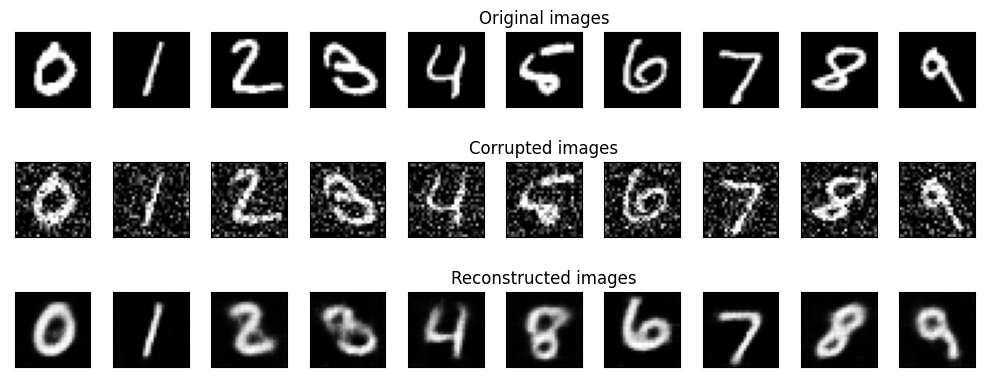

EPOCH 16/30
	 partial train loss (single batch): 0.027773
	 partial train loss (single batch): 0.026443
	 partial train loss (single batch): 0.027321
	 partial train loss (single batch): 0.028681
	 partial train loss (single batch): 0.027890
	 partial train loss (single batch): 0.027077
	 partial train loss (single batch): 0.027272
	 partial train loss (single batch): 0.028286
	 partial train loss (single batch): 0.029288
	 partial train loss (single batch): 0.028101
	 partial train loss (single batch): 0.028107
	 partial train loss (single batch): 0.027857
	 partial train loss (single batch): 0.028415
	 partial train loss (single batch): 0.027103
	 partial train loss (single batch): 0.028628
	 partial train loss (single batch): 0.028651
	 partial train loss (single batch): 0.028048
	 partial train loss (single batch): 0.029786
	 partial train loss (single batch): 0.029048
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch): 0.027730
	 partial train loss (

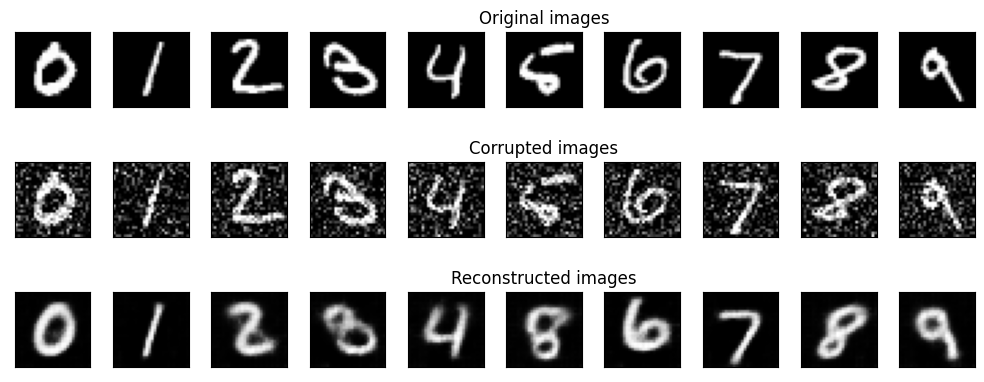

EPOCH 17/30
	 partial train loss (single batch): 0.027710
	 partial train loss (single batch): 0.026511
	 partial train loss (single batch): 0.027249
	 partial train loss (single batch): 0.028582
	 partial train loss (single batch): 0.027654
	 partial train loss (single batch): 0.026993
	 partial train loss (single batch): 0.026888
	 partial train loss (single batch): 0.028155
	 partial train loss (single batch): 0.029126
	 partial train loss (single batch): 0.027865
	 partial train loss (single batch): 0.028067
	 partial train loss (single batch): 0.027674
	 partial train loss (single batch): 0.028547
	 partial train loss (single batch): 0.027288
	 partial train loss (single batch): 0.028397
	 partial train loss (single batch): 0.028132
	 partial train loss (single batch): 0.027974
	 partial train loss (single batch): 0.029497
	 partial train loss (single batch): 0.028992
	 partial train loss (single batch): 0.027392
	 partial train loss (single batch): 0.027626
	 partial train loss (

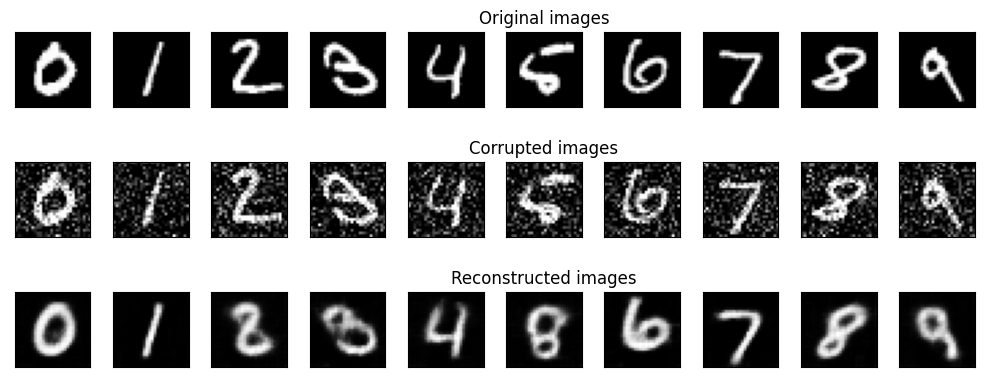

EPOCH 18/30
	 partial train loss (single batch): 0.027669
	 partial train loss (single batch): 0.026298
	 partial train loss (single batch): 0.027228
	 partial train loss (single batch): 0.028402
	 partial train loss (single batch): 0.027820
	 partial train loss (single batch): 0.026932
	 partial train loss (single batch): 0.026924
	 partial train loss (single batch): 0.028008
	 partial train loss (single batch): 0.029037
	 partial train loss (single batch): 0.027924
	 partial train loss (single batch): 0.027958
	 partial train loss (single batch): 0.027523
	 partial train loss (single batch): 0.028417
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.028594
	 partial train loss (single batch): 0.027994
	 partial train loss (single batch): 0.028268
	 partial train loss (single batch): 0.029664
	 partial train loss (single batch): 0.028968
	 partial train loss (single batch): 0.027319
	 partial train loss (single batch): 0.027530
	 partial train loss (

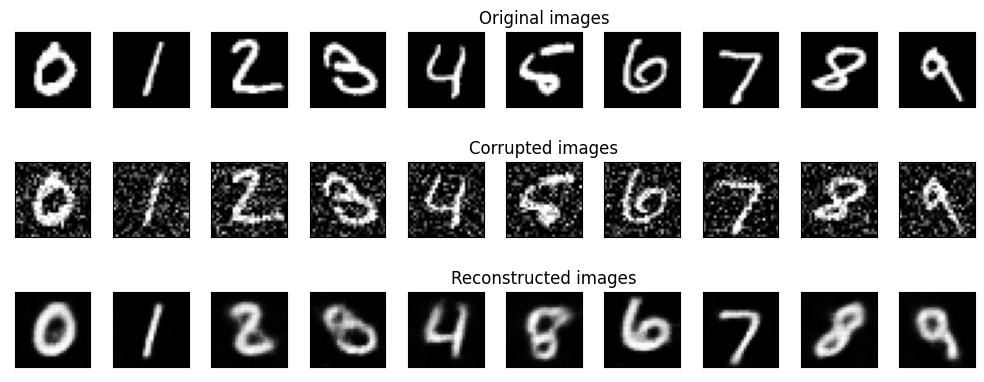

EPOCH 19/30
	 partial train loss (single batch): 0.027621
	 partial train loss (single batch): 0.026118
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.028380
	 partial train loss (single batch): 0.027636
	 partial train loss (single batch): 0.026379
	 partial train loss (single batch): 0.026802
	 partial train loss (single batch): 0.027991
	 partial train loss (single batch): 0.028915
	 partial train loss (single batch): 0.027664
	 partial train loss (single batch): 0.027947
	 partial train loss (single batch): 0.027330
	 partial train loss (single batch): 0.028179
	 partial train loss (single batch): 0.026854
	 partial train loss (single batch): 0.028291
	 partial train loss (single batch): 0.028000
	 partial train loss (single batch): 0.027820
	 partial train loss (single batch): 0.029289
	 partial train loss (single batch): 0.028921
	 partial train loss (single batch): 0.027087
	 partial train loss (single batch): 0.027671
	 partial train loss (

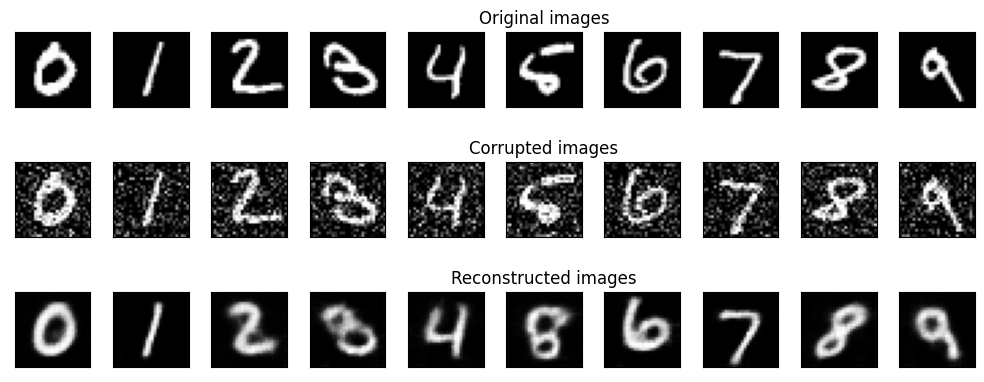

EPOCH 20/30
	 partial train loss (single batch): 0.027315
	 partial train loss (single batch): 0.025864
	 partial train loss (single batch): 0.026989
	 partial train loss (single batch): 0.028449
	 partial train loss (single batch): 0.027401
	 partial train loss (single batch): 0.026792
	 partial train loss (single batch): 0.026759
	 partial train loss (single batch): 0.027653
	 partial train loss (single batch): 0.028730
	 partial train loss (single batch): 0.027947
	 partial train loss (single batch): 0.027706
	 partial train loss (single batch): 0.027261
	 partial train loss (single batch): 0.028418
	 partial train loss (single batch): 0.026998
	 partial train loss (single batch): 0.028288
	 partial train loss (single batch): 0.027578
	 partial train loss (single batch): 0.027563
	 partial train loss (single batch): 0.029709
	 partial train loss (single batch): 0.028440
	 partial train loss (single batch): 0.026889
	 partial train loss (single batch): 0.027364
	 partial train loss (

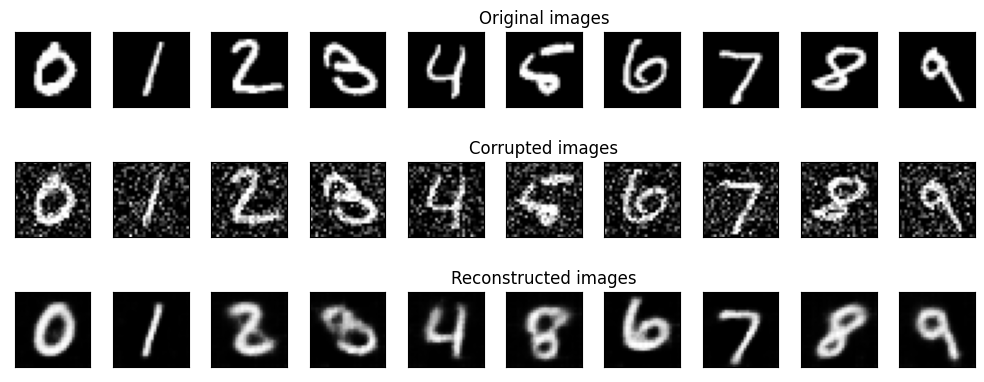

EPOCH 21/30
	 partial train loss (single batch): 0.027316
	 partial train loss (single batch): 0.025871
	 partial train loss (single batch): 0.026810
	 partial train loss (single batch): 0.028254
	 partial train loss (single batch): 0.027491
	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.026542
	 partial train loss (single batch): 0.027629
	 partial train loss (single batch): 0.028693
	 partial train loss (single batch): 0.027518
	 partial train loss (single batch): 0.027645
	 partial train loss (single batch): 0.027044
	 partial train loss (single batch): 0.027926
	 partial train loss (single batch): 0.026864
	 partial train loss (single batch): 0.028006
	 partial train loss (single batch): 0.027657
	 partial train loss (single batch): 0.027896
	 partial train loss (single batch): 0.029259
	 partial train loss (single batch): 0.028397
	 partial train loss (single batch): 0.026969
	 partial train loss (single batch): 0.026991
	 partial train loss (

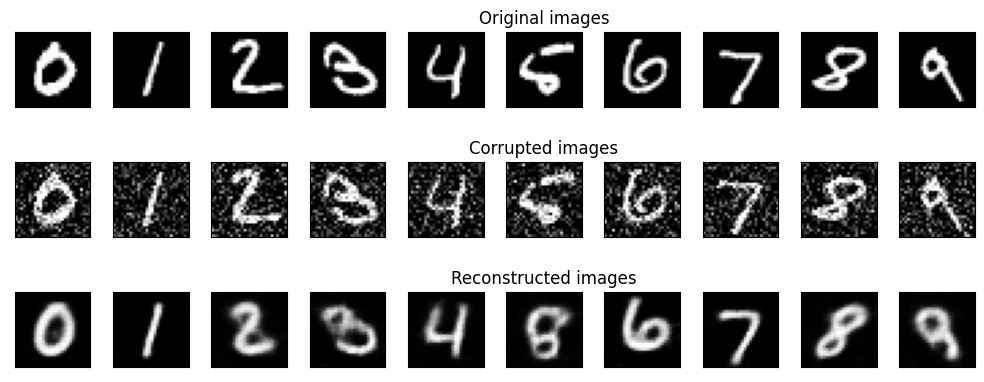

EPOCH 22/30
	 partial train loss (single batch): 0.027360
	 partial train loss (single batch): 0.025841
	 partial train loss (single batch): 0.026674
	 partial train loss (single batch): 0.028064
	 partial train loss (single batch): 0.027289
	 partial train loss (single batch): 0.026553
	 partial train loss (single batch): 0.026583
	 partial train loss (single batch): 0.027468
	 partial train loss (single batch): 0.028213
	 partial train loss (single batch): 0.027503
	 partial train loss (single batch): 0.027787
	 partial train loss (single batch): 0.027047
	 partial train loss (single batch): 0.028036
	 partial train loss (single batch): 0.026699
	 partial train loss (single batch): 0.028155
	 partial train loss (single batch): 0.027671
	 partial train loss (single batch): 0.027871
	 partial train loss (single batch): 0.029266
	 partial train loss (single batch): 0.028364
	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.026999
	 partial train loss (

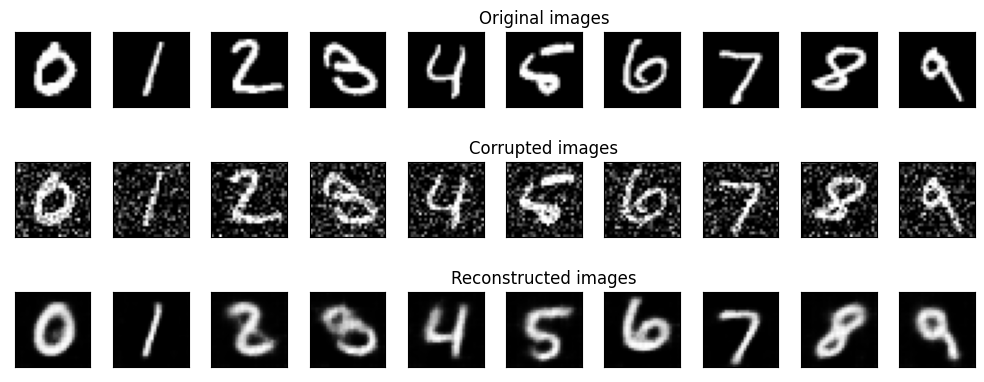

EPOCH 23/30
	 partial train loss (single batch): 0.027419
	 partial train loss (single batch): 0.026025
	 partial train loss (single batch): 0.026411
	 partial train loss (single batch): 0.027844
	 partial train loss (single batch): 0.027125
	 partial train loss (single batch): 0.026246
	 partial train loss (single batch): 0.026564
	 partial train loss (single batch): 0.027372
	 partial train loss (single batch): 0.028257
	 partial train loss (single batch): 0.027087
	 partial train loss (single batch): 0.027458
	 partial train loss (single batch): 0.027101
	 partial train loss (single batch): 0.027900
	 partial train loss (single batch): 0.026548
	 partial train loss (single batch): 0.027946
	 partial train loss (single batch): 0.027606
	 partial train loss (single batch): 0.027708
	 partial train loss (single batch): 0.029411
	 partial train loss (single batch): 0.028190
	 partial train loss (single batch): 0.026753
	 partial train loss (single batch): 0.027006
	 partial train loss (

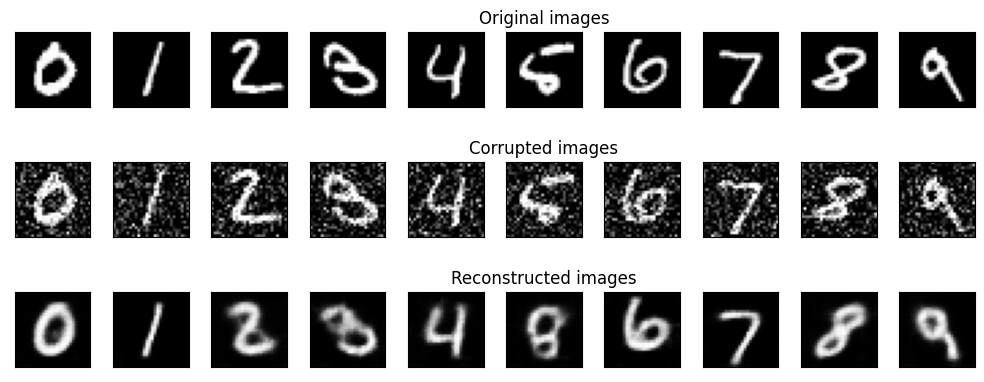

EPOCH 24/30
	 partial train loss (single batch): 0.027029
	 partial train loss (single batch): 0.025963
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.027153
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.027319
	 partial train loss (single batch): 0.028157
	 partial train loss (single batch): 0.027599
	 partial train loss (single batch): 0.027525
	 partial train loss (single batch): 0.026920
	 partial train loss (single batch): 0.027841
	 partial train loss (single batch): 0.026575
	 partial train loss (single batch): 0.028014
	 partial train loss (single batch): 0.027661
	 partial train loss (single batch): 0.027677
	 partial train loss (single batch): 0.029295
	 partial train loss (single batch): 0.028095
	 partial train loss (single batch): 0.026856
	 partial train loss (single batch): 0.027026
	 partial train loss (

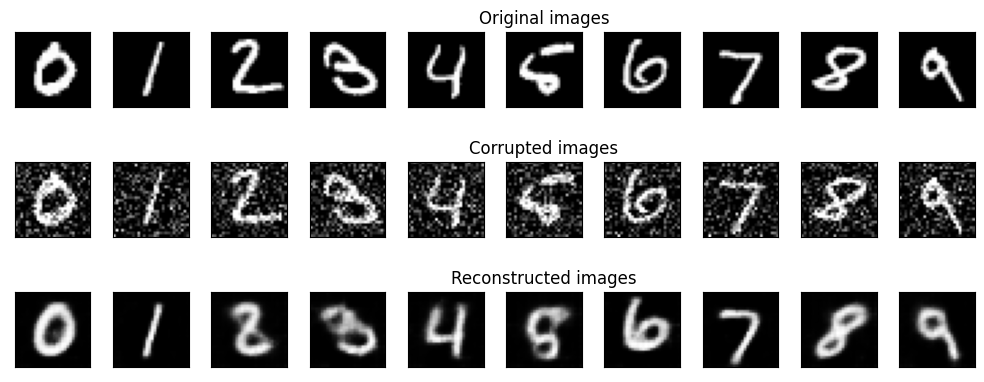

EPOCH 25/30
	 partial train loss (single batch): 0.026961
	 partial train loss (single batch): 0.025775
	 partial train loss (single batch): 0.026468
	 partial train loss (single batch): 0.027968
	 partial train loss (single batch): 0.027111
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.026609
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.028084
	 partial train loss (single batch): 0.027135
	 partial train loss (single batch): 0.027443
	 partial train loss (single batch): 0.026540
	 partial train loss (single batch): 0.027851
	 partial train loss (single batch): 0.026398
	 partial train loss (single batch): 0.028201
	 partial train loss (single batch): 0.027322
	 partial train loss (single batch): 0.027514
	 partial train loss (single batch): 0.029179
	 partial train loss (single batch): 0.028279
	 partial train loss (single batch): 0.026480
	 partial train loss (single batch): 0.027440
	 partial train loss (

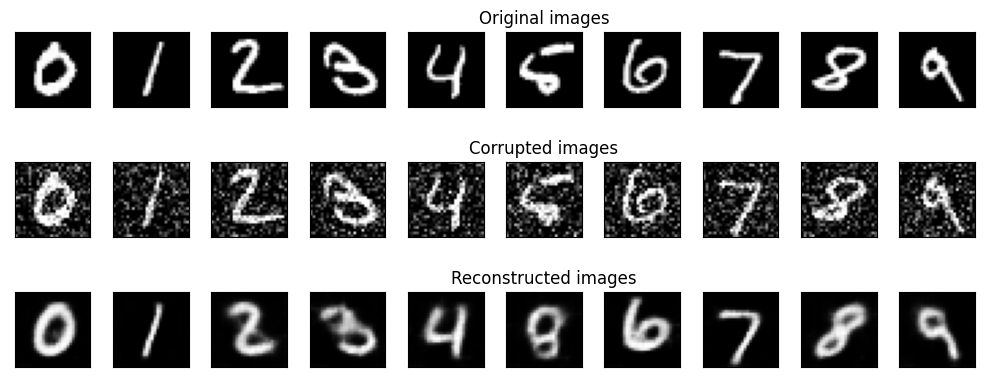

EPOCH 26/30
	 partial train loss (single batch): 0.026702
	 partial train loss (single batch): 0.025765
	 partial train loss (single batch): 0.026505
	 partial train loss (single batch): 0.027679
	 partial train loss (single batch): 0.026802
	 partial train loss (single batch): 0.026364
	 partial train loss (single batch): 0.026006
	 partial train loss (single batch): 0.027319
	 partial train loss (single batch): 0.027938
	 partial train loss (single batch): 0.026970
	 partial train loss (single batch): 0.027221
	 partial train loss (single batch): 0.026564
	 partial train loss (single batch): 0.027746
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.027774
	 partial train loss (single batch): 0.027545
	 partial train loss (single batch): 0.027383
	 partial train loss (single batch): 0.029295
	 partial train loss (single batch): 0.028165
	 partial train loss (single batch): 0.026589
	 partial train loss (single batch): 0.026882
	 partial train loss (

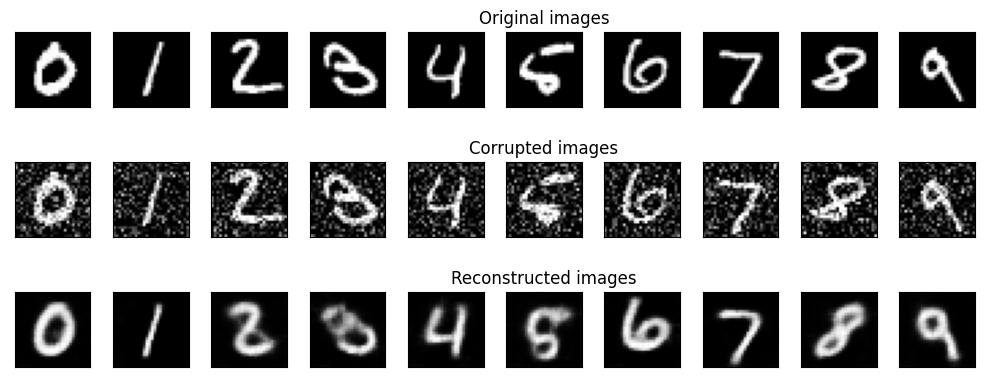

EPOCH 27/30
	 partial train loss (single batch): 0.026637
	 partial train loss (single batch): 0.025582
	 partial train loss (single batch): 0.026249
	 partial train loss (single batch): 0.027488
	 partial train loss (single batch): 0.026883
	 partial train loss (single batch): 0.026147
	 partial train loss (single batch): 0.026103
	 partial train loss (single batch): 0.027251
	 partial train loss (single batch): 0.027786
	 partial train loss (single batch): 0.027086
	 partial train loss (single batch): 0.027097
	 partial train loss (single batch): 0.026617
	 partial train loss (single batch): 0.027642
	 partial train loss (single batch): 0.026221
	 partial train loss (single batch): 0.027462
	 partial train loss (single batch): 0.027539
	 partial train loss (single batch): 0.027264
	 partial train loss (single batch): 0.029107
	 partial train loss (single batch): 0.028045
	 partial train loss (single batch): 0.026274
	 partial train loss (single batch): 0.026851
	 partial train loss (

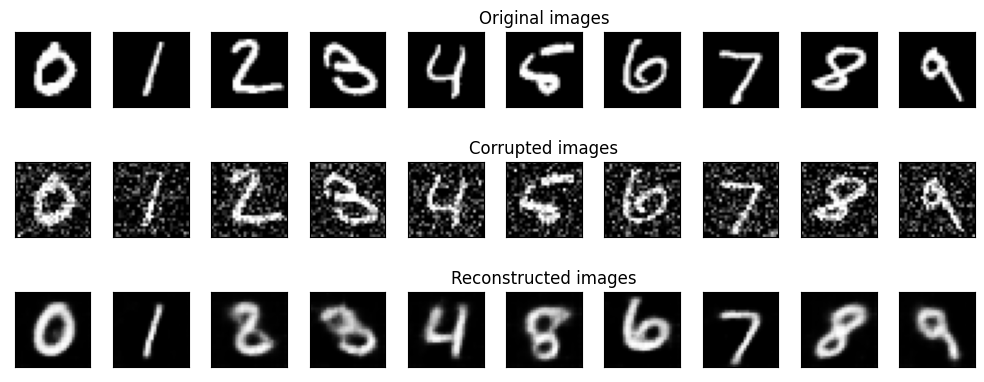

EPOCH 28/30
	 partial train loss (single batch): 0.026668
	 partial train loss (single batch): 0.025401
	 partial train loss (single batch): 0.026058
	 partial train loss (single batch): 0.027693
	 partial train loss (single batch): 0.026860
	 partial train loss (single batch): 0.026197
	 partial train loss (single batch): 0.026221
	 partial train loss (single batch): 0.026978
	 partial train loss (single batch): 0.027705
	 partial train loss (single batch): 0.026924
	 partial train loss (single batch): 0.027177
	 partial train loss (single batch): 0.026327
	 partial train loss (single batch): 0.027689
	 partial train loss (single batch): 0.026043
	 partial train loss (single batch): 0.027701
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.027392
	 partial train loss (single batch): 0.028980
	 partial train loss (single batch): 0.027796
	 partial train loss (single batch): 0.026544
	 partial train loss (single batch): 0.026861
	 partial train loss (

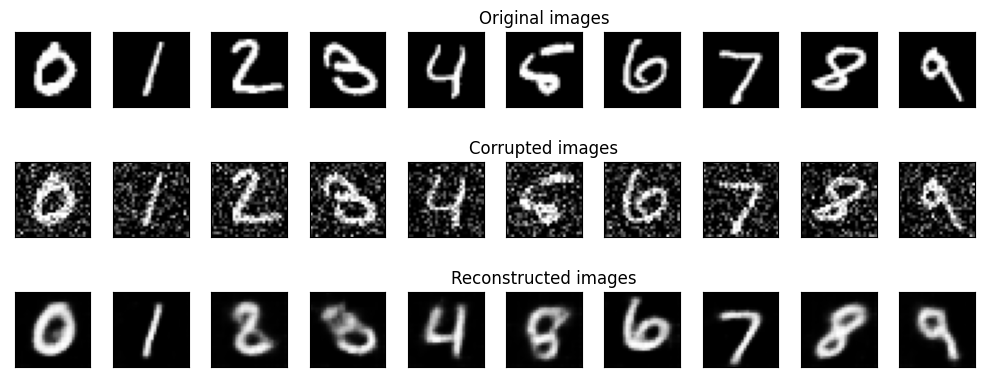

EPOCH 29/30
	 partial train loss (single batch): 0.026310
	 partial train loss (single batch): 0.025343
	 partial train loss (single batch): 0.025825
	 partial train loss (single batch): 0.027439
	 partial train loss (single batch): 0.026549
	 partial train loss (single batch): 0.025814
	 partial train loss (single batch): 0.025961
	 partial train loss (single batch): 0.027233
	 partial train loss (single batch): 0.027498
	 partial train loss (single batch): 0.026910
	 partial train loss (single batch): 0.027150
	 partial train loss (single batch): 0.026265
	 partial train loss (single batch): 0.027177
	 partial train loss (single batch): 0.026134
	 partial train loss (single batch): 0.027430
	 partial train loss (single batch): 0.027123
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch): 0.028924
	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.026213
	 partial train loss (single batch): 0.026644
	 partial train loss (

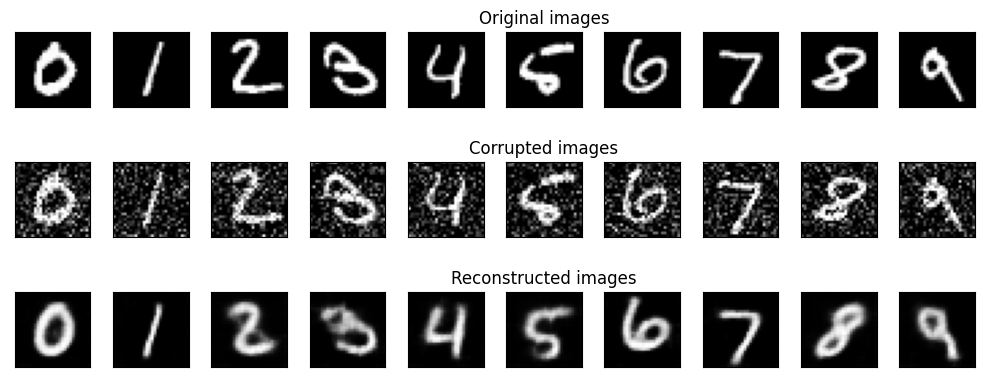

EPOCH 30/30
	 partial train loss (single batch): 0.026558
	 partial train loss (single batch): 0.025369
	 partial train loss (single batch): 0.026187
	 partial train loss (single batch): 0.027420
	 partial train loss (single batch): 0.026453
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.026202
	 partial train loss (single batch): 0.026973
	 partial train loss (single batch): 0.027781
	 partial train loss (single batch): 0.026723
	 partial train loss (single batch): 0.027074
	 partial train loss (single batch): 0.026504
	 partial train loss (single batch): 0.027355
	 partial train loss (single batch): 0.025859
	 partial train loss (single batch): 0.027438
	 partial train loss (single batch): 0.027030
	 partial train loss (single batch): 0.027294
	 partial train loss (single batch): 0.028742
	 partial train loss (single batch): 0.027660
	 partial train loss (single batch): 0.026037
	 partial train loss (single batch): 0.026937
	 partial train loss (

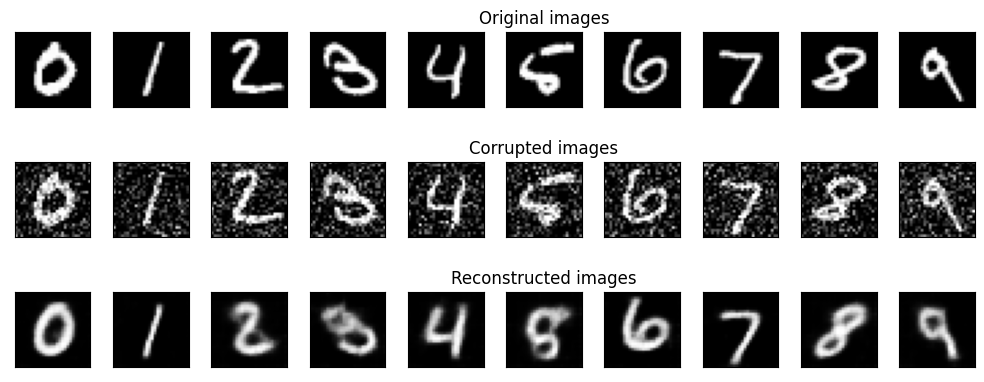

In [13]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
	print('EPOCH %d/%d' % (epoch + 1, num_epochs))
	### Training (use the training function)
	train_loss=train_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=train_loader,
		loss_fn=loss_fn,
		optimizer=optim,noise_factor=noise_factor)
	### Validation (use the testing function)
	val_loss = test_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=valid_loader,
		loss_fn=loss_fn,noise_factor=noise_factor)
	# Print Validationloss
	history_da['train_loss'].append(train_loss)
	history_da['val_loss'].append(val_loss)
	print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

# Generating New Images from the random latent code

tensor([-0.1249,  0.1228,  0.1493, -0.0214])
tensor([0.5842, 0.7395, 0.5396, 0.5581])


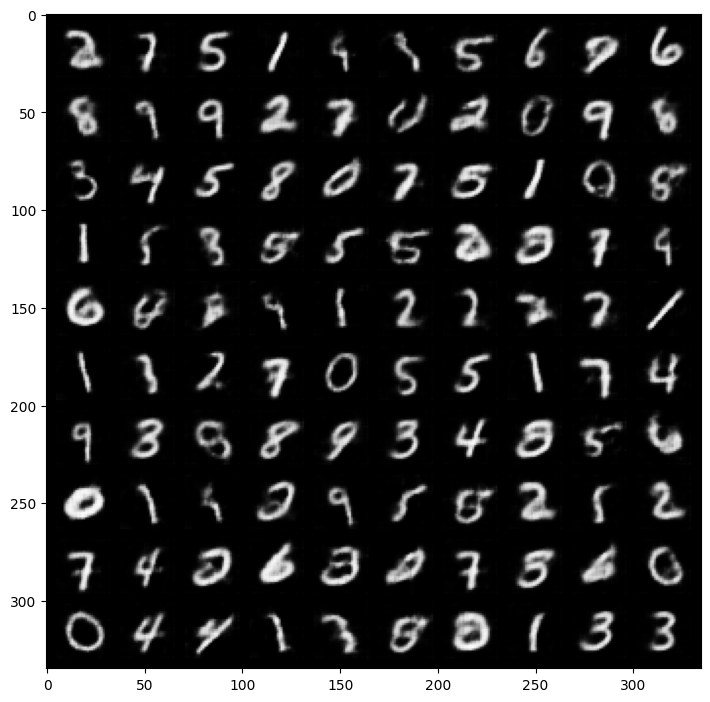

In [15]:
def show_image(img):
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
	# calculate mean and std of latent code, generated taking in test images as inputs
	images, labels = next(iter(test_loader))
	images = images.to(device)
	latent = encoder(images)
	latent = latent.cpu()

	mean = latent.mean(dim=0)
	print(mean)
	std = (latent - mean).pow(2).mean(dim=0).sqrt()
	print(std)

	# sample latent vectors from the normal distribution
	latent = torch.randn(128, d)*std + mean

	# reconstruct images from the random latent vectors
	latent = latent.to(device)
	img_recon = decoder(latent)
	img_recon = img_recon.cpu()

	fig, ax = plt.subplots(figsize=(20, 8.5))
	show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
	plt.show()

# Visualization + Dimensionality Reduction of the Encoded Space

In [21]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:09<00:00, 1050.46it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -1.627930         1.610149         0.830081        -1.070959   
1            0.285691        -0.168844         0.465359        -0.256443   
2           -0.591127         1.280833         0.545225         0.710563   
3            0.116552        -0.824997         0.033244        -0.209892   
4           -0.416871         0.089910        -0.700483        -0.610357   
...               ...              ...              ...              ...   
9995         0.249179        -0.225928         0.985387         0.307921   
9996         1.112632         0.221836         0.285124         0.353666   
9997        -1.066096         0.385502        -0.450711        -0.128869   
9998        -0.228405        -0.317465        -0.603463         0.985215   
9999        -0.271786        -1.089893         0.306768        -0.407384   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [22]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
		   color=encoded_samples.label.astype(str), opacity=0.7)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'color=7<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '7',
              'marker': {'color': '#636efa', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '7',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-1.6279298 , -1.4302087 , -0.92762977, ..., -1.399481  , -1.4983637 ,
                          -0.6064112 ], dtype=float32),
              'xaxis': 'x',
              'y': array([1.6101493, 1.5485249, 1.3225713, ..., 0.9588487, 0.7232554, 0.6865778],
                         dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=2<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '2',
              'marker': {'color': '#EF553B', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '2',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([0.2856906 , 0.4286262 , 0.12545572, ..., 0.41203898, 0.09358662,
                          0.24917863], dtype=float32),
              'xaxis': 'x',
              'y': array([-0.16884407, -0.38174504, -0.01093868, ..., -0.63550174, -0.03086019,
                          -0.22592759], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=1<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '1',
              'marker': {'color': '#00cc96', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '1',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-0.59112716, -0.56779796,  0.1821542 , ..., -0.8864135 , -0.25135538,
                          -0.11044809], dtype=float32),
              'xaxis': 'x',
              'y': array([1.2808326 , 0.93144006, 1.0158412 , ..., 0.56569374, 0.8770613 ,
                          0.8106942 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=0<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '0',
              'marker': {'color': '#ab63fa', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([0.11655205, 0.16235855, 0.34481022, ..., 0.07764055, 0.41774464,
                          0.41581747], dtype=float32),
              'xaxis': 'x',
              'y': array([-0.8249975, -1.0321689, -0.5673623, ..., -0.8667416, -1.0353057,
                          -1.4285452], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=4<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '4',
              'marker': {'color': '#FFA15A', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '4',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-0.41687065, -1.5296354 , -0.6264934 , ..., -0.90533245, -0.87812656,
                          -1.0660961 ], dtype=float32),
              'xaxis': 'x',
              'y': array([0.08991042, 0.77395535, 0.5412307 , ..., 0.30452016, 0.3539384 ,
                          0.38550243], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=9<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '9',
              'marker': {'color': '#19d3f3', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '9',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([ 0.22546194, -0.95170206, -0.4554903 , ..., -0.63702446, -0.7397555 ,
                          -0.5798

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
				 color=encoded_samples.label.astype(str),
				 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed